In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F 
from torch import optim
import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.animation
import math, random
torch.__version__

'2.8.0'

### 通过Sin预测Cos
在介绍循环神经网络时候我们说过，循环神经网络由于其的特殊结构，十分擅长处理时间相关的数据，下面我们就来通过输入sin函数，输出cos函数来实际使用。 

首先，我们还是定义一些超参数

In [2]:
TIME_STEP = 10   # rnn 时序步长数
INPUT_SIZE = 1   # rnn 的输入维度
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
H_SIZE = 64      # of rnn 隐藏单元个数
EPOCHS = 300     # 总共训练次数
h_state = None   # 隐藏层状态

由于是使用sin和cos函数，所以这里不需要`dataloader`，我们直接使用`Numpy`生成数据，`Pytorch`没有π这个常量，所以所有操作都是用`Numpy`完成

In [3]:
steps = np.linspace(0, np.pi*2, 256, dtype = np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)


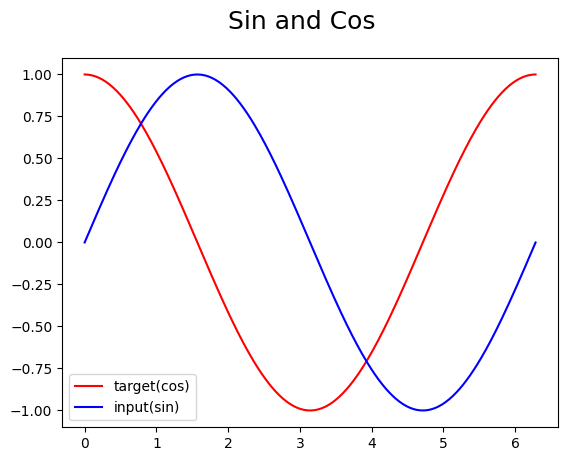

In [4]:
# 可视化数据
plt.figure(1)
plt.suptitle('Sin and Cos',fontsize='18')
plt.plot(steps, y_np, 'r-', label = 'target(cos)')
plt.plot(steps, x_np, 'b-', label = 'input(sin)')
plt.legend(loc = 'best')
plt.show()

In [5]:
# 定义网络结构
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = INPUT_SIZE,
            hidden_size = H_SIZE,
            num_layers = 1,
            batch_first = True,
        )
        self.out = nn.Linear(H_SIZE, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        outs = []    # 保存所有的预测值
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim = 1), h_state
        # 也可使用以下这样的返回值
        # r_out = r_out.view(-1, 32)
        # outs = self.out(r_out)
        # return outs, h_state


# 定义网络
rnn = RNN().to(DEVICE)
optimizer = torch.optim.Adam(rnn.parameters())  # Adam优化，几乎不用调参
criterion = nn.MSELoss()     # 因为最终的结果是一个数值，所以损失函数用均方误差

由于没有测试集，我们训练和测试写在一起

EPOCHS: 19,Loss:0.012692


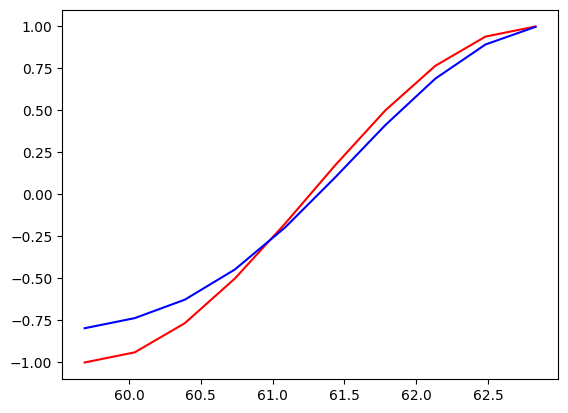

EPOCHS: 39,Loss:0.024746


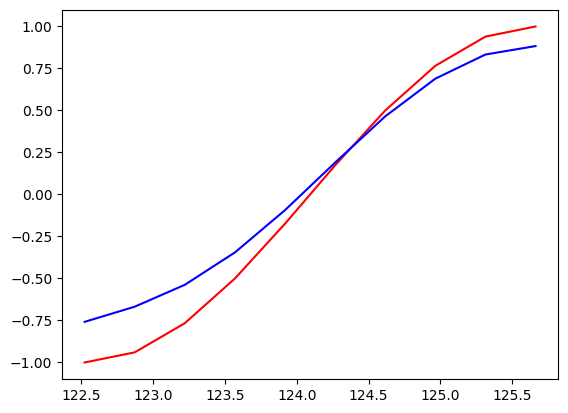

EPOCHS: 59,Loss:0.002619


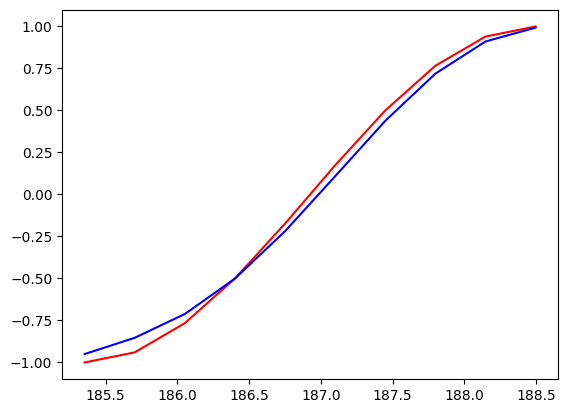

EPOCHS: 79,Loss:0.001469


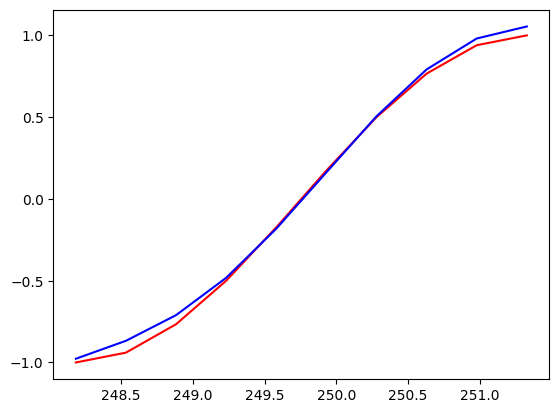

EPOCHS: 99,Loss:0.001677


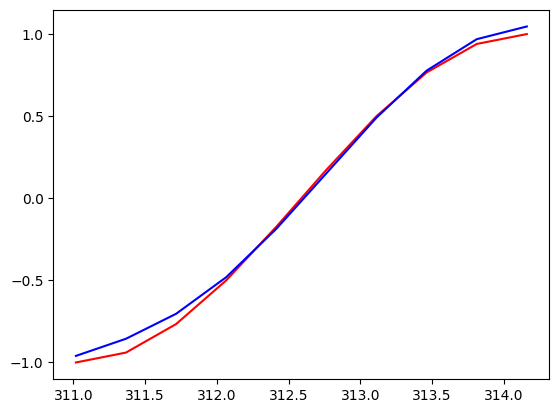

EPOCHS: 119,Loss:0.002067


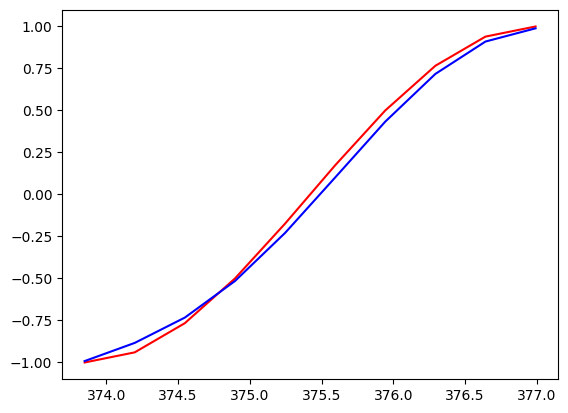

EPOCHS: 139,Loss:0.009486


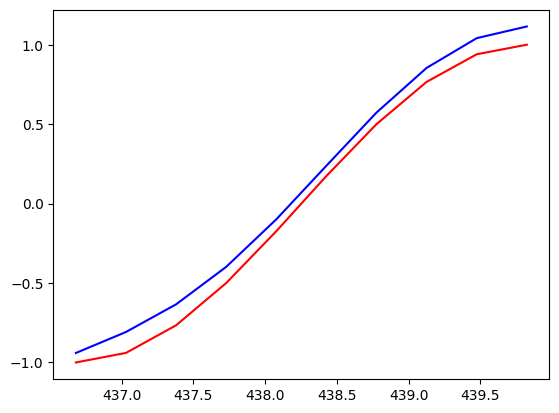

EPOCHS: 159,Loss:0.003396


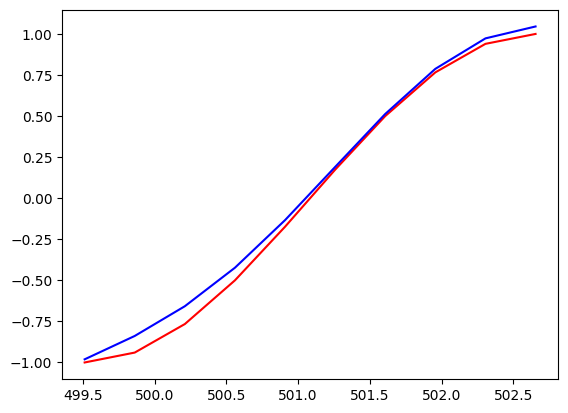

EPOCHS: 179,Loss:0.003587


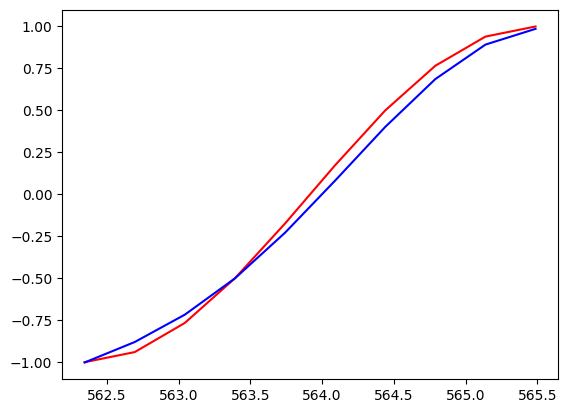

EPOCHS: 199,Loss:0.006160


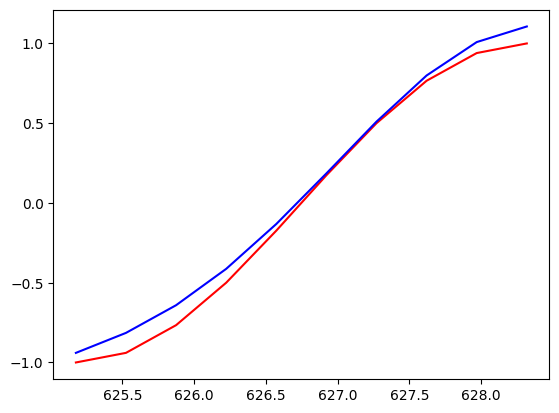

EPOCHS: 219,Loss:0.002247


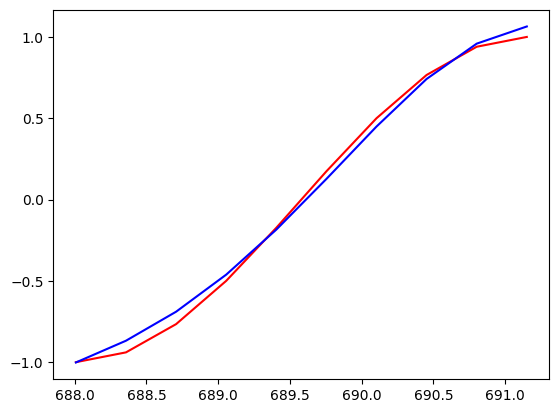

EPOCHS: 239,Loss:0.002601


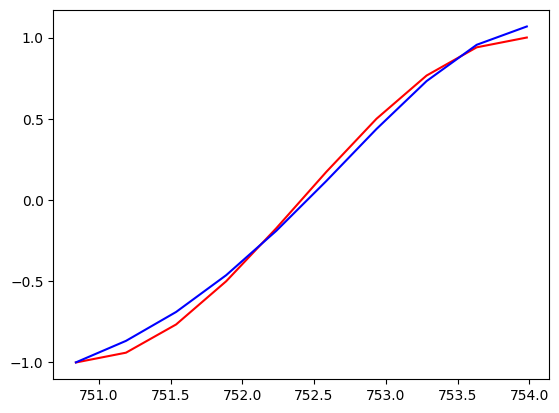

EPOCHS: 259,Loss:0.003125


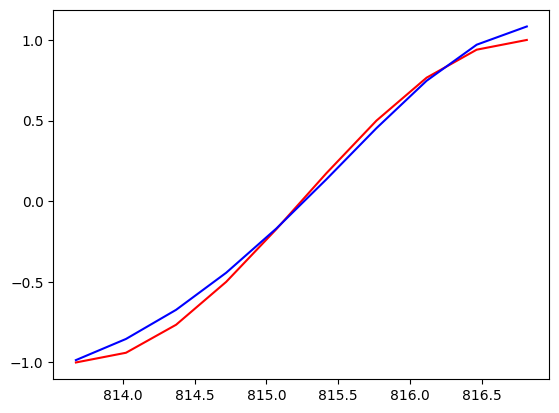

EPOCHS: 279,Loss:0.003502


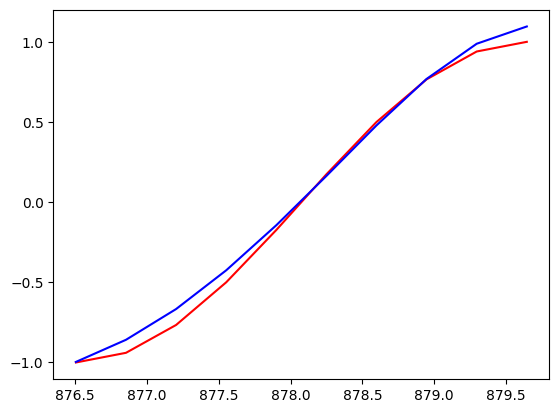

EPOCHS: 299,Loss:0.046316


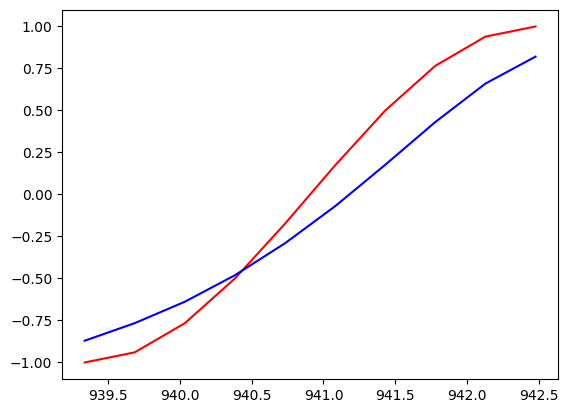

In [7]:
rnn.train()
plt.figure(2)

for step in range(EPOCHS):
    start, end = step * np.pi, (step + 1) * np.pi
    steps = np.linspace(start, end, TIME_STEP, dtype = np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]) #shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    x = x.to(DEVICE)
    prediction, h_state = rnn(x, h_state)  # rnn output

    # 这一步非常重要
    h_state = h_state.data   #重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criterion(prediction.cpu(), y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step + 1) % 20 == 0:
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(steps, y_np.flatten(), 'r-')
        plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(0.01)

蓝色是模型预测的结果，红色是函数的结果，通过300次的训练，已经基本拟合了